In [ ]:
!pip -q install --upgrade torch torchvision scikit-learn

import os, math, random, io, itertools, json, warnings
from typing import List, Tuple, Optional, Dict
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, models

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import hashlib
import json
from pathlib import Path

import shutil
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 56.3 MB/s eta 0:00:00


In [ ]:
!pip -q install gdown==4.6.0

!gdown --fuzzy https://drive.google.com/file/d/1BKJW7yJGfjCL80wCAbcbdOOOzBEH7qCd/view?usp=sharing -O /content/prnu_dataset.zip

!unzip -q -o /content/prnu_dataset.zip -d /content/prnu_dataset

!find /content/prnu_dataset -maxdepth 2 -type d | sort | head -n 50

Downloading...
From: https://drive.google.com/uc?id=1BKJW7yJGfjCL80wCAbcbdOOOzBEH7qCd
To: /content/prnu_dataset.zip
100% 12.4G/12.4G [02:07<00:00, 97.3MB/s]
/content/prnu_dataset
/content/prnu_dataset/data
/content/prnu_dataset/data/biggan
/content/prnu_dataset/data/cyclegan
/content/prnu_dataset/data/dalle_2
/content/prnu_dataset/data/dalle_mini
/content/prnu_dataset/data/gaugan
/content/prnu_dataset/data/glide
/content/prnu_dataset/data/mj
/content/prnu_dataset/data/progan
/content/prnu_dataset/data/sd14
/content/prnu_dataset/data/sd21
/content/prnu_dataset/data/stargan
/content/prnu_dataset/data/stylegan
/content/prnu_dataset/data/stylegan2


In [ ]:
def seed_all(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
seed_all(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [ ]:
class ToResidualTensor:
    def __init__(self, ksize=5, sigma=1.2, eps=1e-6):
        self.ksize = ksize
        self.sigma = sigma
        self.eps = eps
        ax = torch.arange(ksize) - (ksize-1)/2
        xx, yy = torch.meshgrid(ax, ax, indexing='ij')
        kernel = torch.exp(-(xx**2 + yy**2) / (2*sigma*sigma))
        kernel = kernel / kernel.sum()
        self.registered = False
        self.kernel = kernel

    def _register(self, device):
        k = self.kernel.to(device=device, dtype=torch.float32)
        self.weight = k.view(1,1,self.ksize,self.ksize)
        self.registered = True

    def __call__(self, img: Image.Image):
        x = transforms.functional.to_tensor(img)
        if x.shape[0] == 3:
            y = 0.299*x[0] + 0.587*x[1] + 0.114*x[2]
        else:
            y = x[0]
        y = y.unsqueeze(0).unsqueeze(0)
        if not self.registered:
            self._register(y.device)
        y_blur = F.conv2d(y, self.weight, padding=self.ksize//2)
        r = y - y_blur
        mean = r.mean()
        std  = r.std()
        r = (r - mean) / (std + self.eps)
        r3 = r.repeat(1,3,1,1).squeeze(0)
        return r3

In [ ]:
IMG_SIZE = 224
IMG_EXTS = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

train_tfms_geometric = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
])

val_tfms_geometric = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
])

residualizer = ToResidualTensor(ksize=5, sigma=1.2)

def _list_images(d):
    return [os.path.join(d, f) for f in os.listdir(d)
            if os.path.isfile(os.path.join(d,f)) and f.lower().endswith(IMG_EXTS)]

class ResidualBinaryDataset(torch.utils.data.Dataset):
    def __init__(self, root: str, split: str = "train"):
        super().__init__()
        self.samples = []
        model_dirs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        for m in model_dirs:
            real_dir = os.path.join(root, m, "0_real")
            fake_dir = os.path.join(root, m, "1_fake")
            if os.path.isdir(real_dir):
                self.samples += [(p, 0) for p in _list_images(real_dir)]
            if os.path.isdir(fake_dir):
                self.samples += [(p, 1) for p in _list_images(fake_dir)]
        if not self.samples:
            raise RuntimeError(f"No images found under {root}")
        self.tf = train_tfms_geometric if split == "train" else val_tfms_geometric

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        p,y = self.samples[idx]
        img = Image.open(p).convert("RGB"); img = self.tf(img)
        return img, y, p

class ResidualAttributionDataset(torch.utils.data.Dataset):
    """
    root/
      modelA/{0_real,1_fake}/...
      modelB/{0_real,1_fake}/...
      ...
    - 1_fake → 해당 모델 라벨
    - 0_real은 사용하지 않음 (2단계는 fake만)
    """
    def __init__(self, root: str, split: str = "train"):
        super().__init__()
        self.root = root
        self.split = split

        all_model_dirs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]
        model_names = []
        for m in sorted(all_model_dirs):
            fake_dir = os.path.join(root, m, "1_fake")
            if os.path.isdir(fake_dir):
                imgs = _list_images(fake_dir)
                if len(imgs) > 0:
                    model_names.append(m)

        if len(model_names) == 0:
            raise RuntimeError(f"No valid model folders with 1_fake images under: {root}")

        self.model_names = model_names
        self.class_to_idx = {m:i for i,m in enumerate(self.model_names)}

        self.samples: List[Tuple[str,int]] = []
        for m in self.model_names:
            fake_dir = os.path.join(root, m, "1_fake")
            for p in _list_images(fake_dir):
                self.samples.append((p, self.class_to_idx[m]))

        if len(self.samples) == 0:
            raise RuntimeError(f"No fake images found under: {root}")

        self.transform = train_tfms_geometric if split == "train" else val_tfms_geometric

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, label, path

def _class_counts_from_indices(dataset, indices: List[int], num_classes: int):
    counts = [0]*num_classes
    for i in indices:
        _, y, _ = dataset[i]
        counts[y] += 1
    return counts

def _split_indices(n: int, val_ratio: float = 0.2, seed: int = 42):
    g = torch.Generator().manual_seed(seed)
    indices = torch.randperm(n, generator=g).tolist()
    n_val = max(1, int(len(indices)*val_ratio))
    return indices[n_val:], indices[:n_val]  # train, val

def _make_loader_with_residual(dataset, batch_size=32, num_workers=2, use_sampler=True):
    def _collate_with_residual(batch):
        imgs, labels, _paths = zip(*batch)
        tensors = [residualizer(img) for img in imgs]
        x = torch.stack(tensors, dim=0)
        y = torch.tensor(labels, dtype=torch.long)
        return x, y
    if use_sampler:
        labels = [dataset[i][1] for i in range(len(dataset))]
        K = max(labels)+1
        counts = [1]*K
        for y in labels: counts[y] += 1
        class_w = torch.tensor([1.0/c for c in counts], dtype=torch.float32)
        sample_w = [class_w[y].item() for y in labels]
        sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                          num_workers=num_workers, pin_memory=True,
                          collate_fn=_collate_with_residual)
    else:
        return DataLoader(dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True,
                          collate_fn=_collate_with_residual)

def make_binary_loaders(dataset_root: str, batch_size=32, num_workers=2, val_ratio=0.2, seed=42):
    all_samples = []
    model_dirs = [d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))]

    for m in model_dirs:
        real_dir = os.path.join(dataset_root, m, "0_real")
        fake_dir = os.path.join(dataset_root, m, "1_fake")
        if os.path.isdir(real_dir):
            all_samples += [(p, 0, p) for p in _list_images(real_dir)]
        if os.path.isdir(fake_dir):
            all_samples += [(p, 1, p) for p in _list_images(fake_dir)]

    tr_idx, va_idx = _split_indices(len(all_samples), val_ratio, seed)
    tr_samples = [all_samples[i] for i in tr_idx]
    va_samples = [all_samples[i] for i in va_idx]

    class BinarySubset(torch.utils.data.Dataset):
        def __init__(self, samples, split):
            self.samples = samples
            self.tf = train_tfms_geometric if split == "train" else val_tfms_geometric

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, i):
            path, label, _ = self.samples[i]
            img = Image.open(path).convert("RGB")
            img = self.tf(img)
            return img, label, path

    tr_ds = BinarySubset(tr_samples, "train")
    va_ds = BinarySubset(va_samples, "val")

    def _collate(batch):
        imgs, labels, _ = zip(*batch)
        x = torch.stack([residualizer(im) for im in imgs], 0)
        y = torch.tensor(labels, dtype=torch.long)
        return x, y

    labels = [y for (_, y, _) in tr_samples]
    K = max(labels) + 1
    counts = [1] * K
    for y in labels:
        counts[y] += 1
    class_w = torch.tensor([1.0/c for c in counts])
    sample_w = [class_w[y].item() for y in labels]
    sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)

    tr_loader = DataLoader(tr_ds, batch_size=batch_size, sampler=sampler,
                          num_workers=num_workers, pin_memory=True, collate_fn=_collate)
    va_loader = DataLoader(va_ds, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True, collate_fn=_collate)

    print(f"[Binary Data] train={len(tr_samples)} val={len(va_samples)}")
    return tr_loader, va_loader

def make_attr_loaders(dataset_root: str, batch_size=32, num_workers=2, val_ratio=0.2, seed=42):
    full = ResidualAttributionDataset(dataset_root, split="train")
    class_names = full.model_names
    train_idx, val_idx = _split_indices(len(full), val_ratio, seed)

    class Subset(torch.utils.data.Dataset):
        def __init__(self, base, idxs, split):
            self.base = base; self.idxs = idxs
            self.tf = train_tfms_geometric if split=="train" else val_tfms_geometric
        def __len__(self): return len(self.idxs)
        def __getitem__(self, i):
            _, y, p = self.base[self.idxs[i]]
            img = Image.open(p).convert('RGB')
            img = self.tf(img)
            return img, y, p

    train_ds = Subset(full, train_idx, "train")
    val_ds   = Subset(full, val_idx,   "val")
    train_loader = _make_loader_with_residual(train_ds, batch_size, num_workers, use_sampler=True)
    val_loader   = _make_loader_with_residual(val_ds,   batch_size, num_workers, use_sampler=False)

    print(f"[Attribution Data] classes={class_names}")
    print(f"[Attribution Data] train={len(train_idx)} val={len(val_idx)}")
    return train_loader, val_loader, class_names

In [ ]:
class ResNetHead(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_f = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_f, num_classes)

    def forward(self, x):
        return self.backbone(x)

In [ ]:
def accuracy_from_logits(logits, y):
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()

def _plot_cm(cm, class_names, title="Confusion Matrix", normalize=True):
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-12)
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(class_names)), yticks=np.arange(len(class_names)),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True', xlabel='Predicted', title=title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.2f}" if normalize else int(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

def _print_report_and_cm(y_true, y_pred, class_names=None, title_prefix=""):
    if class_names is None:
        class_names = ["real", "fake"] if len(set(y_true)) <= 2 else [str(i) for i in sorted(set(y_true))]
    print(f"\n{title_prefix}Classification Report")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    print(f"{title_prefix}Confusion Matrix (counts)")
    print(cm)
    _plot_cm(cm, class_names, title=f"{title_prefix}Confusion Matrix (normalized)")

def train_one_epoch(model, loader, optimizer, scaler, criterion):
    model.train()
    loss_m = acc_m = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        acc = accuracy_from_logits(logits, y)
        loss_m += loss.item()
        acc_m += acc
    n = len(loader)
    return loss_m/n, acc_m/n

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    loss_m = acc_m = 0.0
    all_true, all_pred = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            logits = model(x)
            loss = criterion(logits, y)
        acc = accuracy_from_logits(logits, y)
        loss_m += loss.item()
        acc_m += acc
        all_true.extend(y.detach().cpu().tolist())
        all_pred.extend(logits.argmax(dim=1).detach().cpu().tolist())
    n = len(loader)
    return (loss_m/n, acc_m/n, np.array(all_true), np.array(all_pred))

def fit_model(model, train_loader, val_loader, epochs=8, lr=1e-3, wd=1e-4,
              head_freeze=True, save_path="/content/best.pth", label_smoothing=0.1,
              class_names=None, print_metrics=True):
    """
    캐시 없는 훈련 함수
    """
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    params_all = list(model.parameters())
    if head_freeze:
        for p in model.backbone.layer1.parameters(): p.requires_grad = False
        for p in model.backbone.layer2.parameters(): p.requires_grad = False
        for p in model.backbone.layer3.parameters(): p.requires_grad = False
        for p in model.backbone.layer4.parameters(): p.requires_grad = False
        for p in model.backbone.fc.parameters():     p.requires_grad = True

    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                            lr=lr, weight_decay=wd)
    scaler = torch.amp.GradScaler('cuda', enabled=(device.type=='cuda'))
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)

    tr_losses=[]; va_losses=[]; tr_accs=[]; va_accs=[]
    best_acc=-1.0

    head_epochs = max(3, min(5, epochs//2))
    print(f"[Training] Starting training with {epochs} epochs (head: {head_epochs}, finetune: {epochs-head_epochs})")

    for ep in range(1, head_epochs+1):
        tl, ta = train_one_epoch(model, train_loader, opt, scaler, criterion)
        vl, va, y_true, y_pred = evaluate(model, val_loader, criterion)
        scheduler.step()
        tr_losses.append(tl); tr_accs.append(ta); va_losses.append(vl); va_accs.append(va)
        print(f"[Head {ep}/{head_epochs}] train {tl:.4f}/{ta:.3f} | val {vl:.4f}/{va:.3f}")
        if va > best_acc:
            best_acc = va
            torch.save(model.state_dict(), save_path)
            print("  -> saved best (head stage)")

    for p in model.parameters(): p.requires_grad = True
    opt = torch.optim.AdamW(model.parameters(), lr=max(lr*0.03, 3e-5), weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, epochs-head_epochs))

    for ep in range(head_epochs+1, epochs+1):
        tl, ta = train_one_epoch(model, train_loader, opt, scaler, criterion)
        vl, va, y_true, y_pred = evaluate(model, val_loader, criterion)
        scheduler.step()
        tr_losses.append(tl); tr_accs.append(ta); va_losses.append(vl); va_accs.append(va)
        print(f"[Finetune {ep}/{epochs}] train {tl:.4f}/{ta:.3f} | val {vl:.4f}/{va:.3f}")
        if va > best_acc:
            best_acc = va
            torch.save(model.state_dict(), save_path)
            print("  -> saved best")

    epochs_range = range(1, len(tr_losses)+1)
    plt.figure(figsize=(7,5))
    plt.plot(epochs_range, tr_losses, marker='o', label='Train Loss')
    plt.plot(epochs_range, va_losses, marker='s', label='Val Loss')
    plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True); plt.legend(); plt.show()

    plt.figure(figsize=(7,5))
    plt.plot(epochs_range, tr_accs, marker='o', label='Train Acc')
    plt.plot(epochs_range, va_accs, marker='s', label='Val Acc')
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.grid(True); plt.legend(); plt.show()

    if os.path.exists(save_path):
        state = torch.load(save_path, map_location=device)
        model.load_state_dict(state)
        model.to(device).eval()

    print(f"[Best Val Acc] {best_acc:.3f} (saved to {save_path})")

    if val_loader is not None and print_metrics:
        vl, va, y_true, y_pred = evaluate(model, val_loader, criterion)
        print(f"[Final Eval @ Best CKPT] val loss/acc: {vl:.4f}/{va:.3f}")
        _print_report_and_cm(y_true, y_pred, class_names=class_names, title_prefix="[Best CKPT] ")

    return best_acc

In [ ]:
@torch.no_grad()
def _softmax_np(logits: torch.Tensor):
    p = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
    return p

@torch.no_grad()
def predict_two_stage(
    img_path: str,
    binary_model: nn.Module,
    attr_model: nn.Module,
    attr_class_names: List[str],
    tta: bool = True,
    fake_threshold: float = 0.5
):
    """
    1단계에서 fake 확률 >= fake_threshold 이면 2단계 attribution.
    반환:
      {
        'stage1': {'pred': 'real'|'fake', 'prob_fake': float},
        'stage2': {'pred_model': str|None, 'prob': float|None, 'probs': list|None}
      }
    """
    # 공통 변환
    img = Image.open(img_path).convert('RGB')
    xg = val_tfms_geometric(img)
    xr = residualizer(xg).unsqueeze(0).to(device)

    # ---- Stage 1: real/fake
    binary_model.eval()
    with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
        logit_b = binary_model(xr)
        if tta: logit_b = logit_b + binary_model(torch.flip(xr, dims=[3]))
    prob_fake = float(_softmax_np(logit_b)[1])  # [real, fake] 순으로 가정
    stage1_pred = 'fake' if prob_fake >= fake_threshold else 'real'

    # ---- Stage 2: only if fake
    stage2 = {'pred_model': None, 'prob': None, 'probs': None}
    if stage1_pred == 'fake':
        attr_model.eval()
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            logit_a = attr_model(xr)
            if tta: logit_a = logit_a + attr_model(torch.flip(xr, dims=[3]))
        probs = _softmax_np(logit_a)
        idx = int(np.argmax(probs))
        stage2 = {'pred_model': attr_class_names[idx], 'prob': float(probs[idx]), 'probs': probs.tolist()}

    return {
        'stage1': {'pred': stage1_pred, 'prob_fake': prob_fake},
        'stage2': stage2
    }

In [ ]:
def _plot_cm(cm, class_names, title="Confusion Matrix", normalize=True):
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-12)
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(class_names)), yticks=np.arange(len(class_names)),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True', xlabel='Predicted', title=title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.2f}" if normalize else int(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

In [ ]:
if "_plot_cm" not in globals():
    import matplotlib.pyplot as plt
    def _plot_cm(cm, class_names, title="Confusion Matrix", normalize=True):
        if normalize:
            cm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-12)
        fig, ax = plt.subplots(figsize=(6, 5))
        im = ax.imshow(cm, interpolation='nearest')
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(len(class_names)), yticks=np.arange(len(class_names)),
               xticklabels=class_names, yticklabels=class_names,
               ylabel='True', xlabel='Predicted', title=title)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        thresh = cm.max() / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, f"{cm[i, j]:.2f}" if normalize else int(cm[i, j]),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.show()

In [ ]:
try:
    device
except NameError:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PIN_MEM = (device.type == 'cuda')
warnings.filterwarnings('ignore', category=UserWarning, module='torch.utils.data.dataloader')

try:
    residualizer
except NameError:
    class _IdentityResidual:
        def __call__(self, img):
            if isinstance(img, torch.Tensor):
                return img
            from torchvision.transforms.functional import to_tensor
            return to_tensor(img)
    residualizer = _IdentityResidual()

try:
    train_tfms_geometric
    val_tfms_geometric
except NameError:
    train_tfms_geometric = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
    ])
    val_tfms_geometric = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
    ])

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)
    return p


def _list_images(d: str) -> List[str]:
    if not os.path.isdir(d):
        return []
    return [os.path.join(d, f) for f in os.listdir(d)
            if os.path.isfile(os.path.join(d, f)) and f.lower().endswith(IMG_EXTS)]


def _find_real_fake_dirs(model_dir: str) -> Optional[Tuple[str, str]]:
    direct_real = os.path.join(model_dir, '0_real')
    direct_fake = os.path.join(model_dir, '1_fake')
    if os.path.isdir(direct_real) or os.path.isdir(direct_fake):
        return direct_real, direct_fake
    leaf = os.path.basename(os.path.normpath(model_dir))
    nested = os.path.join(model_dir, leaf)
    nested_real = os.path.join(nested, '0_real')
    nested_fake = os.path.join(nested, '1_fake')
    if os.path.isdir(nested_real) or os.path.isdir(nested_fake):
        return nested_real, nested_fake
    return None


def _find_file_recursive(start_dir: str, patterns: List[str]) -> Optional[str]:
    for root, _, files in os.walk(start_dir):
        for f in files:
            if f.endswith('.pth') and all(p in f for p in patterns):
                return os.path.join(root, f)
    return None

def _split_indices(n:int, val_ratio:float=0.2, seed:int=42):
    g = torch.Generator().manual_seed(seed)
    idx = torch.randperm(n, generator=g).tolist()
    n_val = max(1, int(n*val_ratio))
    return idx[n_val:], idx[:n_val]

In [ ]:
def evaluate_two_stage_full_val(
    dataset_root: str,
    binary_model: nn.Module,
    attr_model: nn.Module,
    attr_class_names: List[str],
    val_ratio: float = 0.2,
    seed: int = 42,
    batch_size: int = 64,
    tta: bool = True,
    fake_threshold: float = 0.5,
):

    full = ResidualBinaryDataset(dataset_root, split="train")
    train_idx, val_idx = _split_indices(len(full), val_ratio, seed)

    class ValDataset(torch.utils.data.Dataset):
        def __init__(self, base, idxs):
            self.base = base
            self.idxs = idxs
            self.tf = val_tfms_geometric

        def __len__(self):
            return len(self.idxs)

        def __getitem__(self, i):
            _, y_bin, p = self.base[self.idxs[i]]
            img = Image.open(p).convert('RGB')
            x = residualizer(self.tf(img))
            if y_bin == 0:
                y_e2e = 0
            else:
                rel = os.path.relpath(p, dataset_root)
                model_name = rel.split(os.sep)[0]
                if model_name in attr_class_names:
                    y_e2e = 1 + attr_class_names.index(model_name)
                else:
                    y_e2e = 0  # unknown으로 처리
            return x, y_bin, y_e2e

    val_ds = ValDataset(full, val_idx)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                           num_workers=2, pin_memory=True)

    y_true_bin, y_pred_bin = [], []
    y_true_attr, y_pred_attr = [], []

    binary_model.eval()
    attr_model.eval()

    with torch.no_grad():
        for x_batch, y_bin_batch, y_e2e_batch in val_loader:
            x_batch = x_batch.to(device)

            logits_bin = binary_model(x_batch)
            if tta:
                logits_bin = logits_bin + binary_model(torch.flip(x_batch, dims=[3]))

            probs_bin = torch.softmax(logits_bin, dim=1)
            pred_bin = (probs_bin[:, 1] >= fake_threshold).long()

            logits_attr = attr_model(x_batch)
            if tta:
                logits_attr = logits_attr + attr_model(torch.flip(x_batch, dims=[3]))
            pred_attr = logits_attr.argmax(dim=1)

            y_true_bin.extend(y_bin_batch.tolist())
            y_pred_bin.extend(pred_bin.cpu().tolist())

            fake_mask = (y_bin_batch == 1) & (pred_bin.cpu() == 1)
            if fake_mask.any():

                true_attr = (y_e2e_batch[fake_mask] - 1).clamp(min=0)
                y_true_attr.extend(true_attr.tolist())
                y_pred_attr.extend(pred_attr[fake_mask].cpu().tolist())

    # Confusion Matrix 1: Binary
    print("\n========== Stage 1: Binary Classification ==========")
    cm1 = confusion_matrix(y_true_bin, y_pred_bin, labels=[0, 1])
    print("Confusion Matrix:")
    print(cm1)
    _plot_cm(cm1, ["real", "fake"], title="Stage 1: Real vs Fake")

    print("\nClassification Report:")
    print(classification_report(y_true_bin, y_pred_bin,
                              target_names=["real", "fake"], digits=3))

    # Confusion Matrix 2: Attribution
    if len(y_true_attr) > 0:
        print("\n========== Stage 2: Attribution (13 classes) ==========")
        cm2 = confusion_matrix(y_true_attr, y_pred_attr,
                              labels=list(range(len(attr_class_names))))
        print("Confusion Matrix:")
        print(cm2)
        _plot_cm(cm2, attr_class_names, title="Stage 2: Model Attribution")

        print("\nClassification Report:")
        print(classification_report(y_true_attr, y_pred_attr,
                                  target_names=attr_class_names, digits=3))
    else:
        print("\n[Stage 2] No fake samples correctly identified by Stage 1")

    return {"cm_binary": cm1, "cm_attr": cm2 if len(y_true_attr) > 0 else None}

Training Stage 1: Binary Classification
[Binary Data] train=60276 val=15068
Loading existing binary checkpoint from /content/prnu_dataset/data/_ckpts_multi/binary_full_best.pth

Training Stage 2: Attribution Classification
[Attribution Data] classes=['biggan', 'cyclegan', 'dalle_2', 'dalle_mini', 'gaugan', 'glide', 'mj', 'progan', 'sd14', 'sd21', 'stargan', 'stylegan', 'stylegan2']
[Attribution Data] train=30138 val=7534
Attribution classes: ['biggan', 'cyclegan', 'dalle_2', 'dalle_mini', 'gaugan', 'glide', 'mj', 'progan', 'sd14', 'sd21', 'stargan', 'stylegan', 'stylegan2']
Loading existing attribution checkpoint from /content/prnu_dataset/data/_ckpts_multi/attr_full_best.pth

Evaluating Two-Stage Pipeline on Test Set


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



========== Stage 1: Binary Classification ==========
Confusion Matrix:
[[6923  538]
 [ 468 7139]]


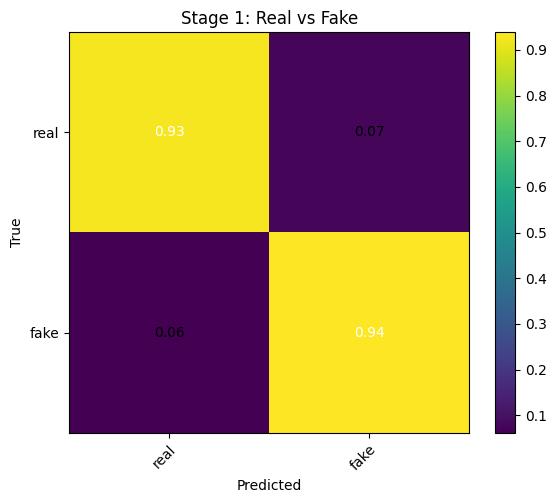


Classification Report:
              precision    recall  f1-score   support

        real      0.937     0.928     0.932      7461
        fake      0.930     0.938     0.934      7607

    accuracy                          0.933     15068
   macro avg      0.933     0.933     0.933     15068
weighted avg      0.933     0.933     0.933     15068


========== Stage 2: Attribution (13 classes) ==========
Confusion Matrix:
[[ 283    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0  140    0    0    0    1    0    0    0    0    0    0    0]
 [   0    0   75    0    0    0    0    0    5    8    0    0    1]
 [   0    0    0  486    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0  915    0    0    1    0    0    0    0    0]
 [   0    0    0    0    0  496    0    0    0    0    0    0    0]
 [   1    0    0    3    0    1  449    0    0    0    0    0    0]
 [   0    0    0    0    1    0    1  616    0    0    0    0    0]
 [   0    1    0    1    0    

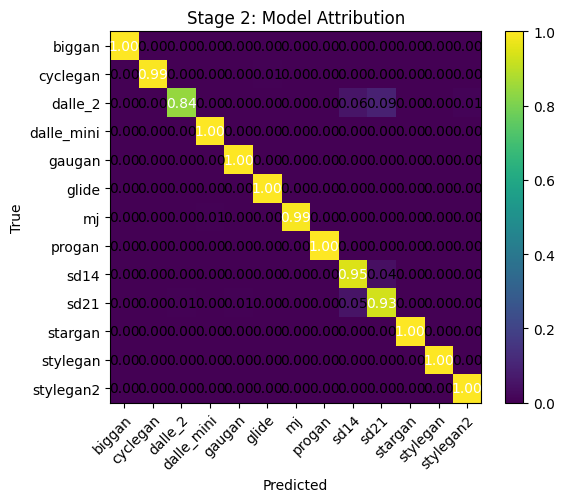


Classification Report:
              precision    recall  f1-score   support

      biggan      0.996     1.000     0.998       283
    cyclegan      0.993     0.993     0.993       141
     dalle_2      0.974     0.843     0.904        89
  dalle_mini      0.992     1.000     0.996       486
      gaugan      0.997     0.999     0.998       916
       glide      0.994     1.000     0.997       496
          mj      0.996     0.989     0.992       454
      progan      0.990     0.997     0.994       618
        sd14      0.939     0.948     0.943       405
        sd21      0.937     0.932     0.935       385
     stargan      1.000     1.000     1.000       303
    stylegan      0.999     0.998     0.999      1118
   stylegan2      0.999     0.999     0.999      1445

    accuracy                          0.990      7139
   macro avg      0.985     0.977     0.981      7139
weighted avg      0.990     0.990     0.990      7139


Evaluation Complete!


In [ ]:
try:
    device
except NameError:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PIN_MEM = (device.type == 'cuda')
warnings.filterwarnings('ignore', category=UserWarning, module='torch.utils.data.dataloader')

try:
    residualizer
except NameError:
    class _IdentityResidual:
        def __call__(self, img: Image.Image):
            from torchvision import transforms as _T
            return _T.functional.to_tensor(img)
    residualizer = _IdentityResidual()

try:
    train_tfms_geometric
    val_tfms_geometric
except NameError:
    train_tfms_geometric = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
    ])
    val_tfms_geometric = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
    ])

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)
    return p


def _list_images(d: str) -> List[str]:
    if not os.path.isdir(d):
        return []
    return [os.path.join(d, f) for f in os.listdir(d)
            if os.path.isfile(os.path.join(d, f)) and f.lower().endswith(IMG_EXTS)]


def _find_real_fake_dirs(model_dir: str) -> Optional[Tuple[str, str]]:
    # case 1: <model_dir>/{0_real,1_fake}
    direct_real = os.path.join(model_dir, '0_real')
    direct_fake = os.path.join(model_dir, '1_fake')
    if os.path.isdir(direct_real) or os.path.isdir(direct_fake):
        return direct_real, direct_fake
    # case 2: <model_dir>/<model>/{0_real,1_fake}
    leaf = os.path.basename(os.path.normpath(model_dir))
    nested = os.path.join(model_dir, leaf)
    nested_real = os.path.join(nested, '0_real')
    nested_fake = os.path.join(nested, '1_fake')
    if os.path.isdir(nested_real) or os.path.isdir(nested_fake):
        return nested_real, nested_fake
    return None


def _find_file_recursive(start_dir: str, patterns: List[str]) -> Optional[str]:
    for root, _, files in os.walk(start_dir):
        for f in files:
            if f.endswith('.pth') and all(p in f for p in patterns):
                return os.path.join(root, f)
    return None

def _split_indices(n:int, val_ratio:float=0.2, seed:int=42):
    g = torch.Generator().manual_seed(seed)
    idx = torch.randperm(n, generator=g).tolist()
    n_val = max(1, int(n*val_ratio))
    return idx[n_val:], idx[:n_val]

import shutil

if __name__ == "__main__":
    BASE_DATASET_ROOT = "/content/prnu_dataset/data"
    VAL_RATIO = 0.2
    SEED = 42

    # 체크포인트 경로 설정
    ensure_dir(os.path.join(BASE_DATASET_ROOT, "_ckpts_multi"))
    binary_ckpt_path = os.path.join(BASE_DATASET_ROOT, "_ckpts_multi", "binary_full_best.pth")
    attr_ckpt_path = os.path.join(BASE_DATASET_ROOT, "_ckpts_multi", "attr_full_best.pth")

    # ---- 1단계: Binary 분류 ----
    print("="*60)
    print("Training Stage 1: Binary Classification")
    print("="*60)

    train_loader, val_loader = make_binary_loaders(
        BASE_DATASET_ROOT,
        batch_size=32,
        num_workers=2,
        val_ratio=VAL_RATIO,
        seed=SEED
    )

    binary_model = ResNetHead(num_classes=2).to(device)

    # 체크포인트가 있으면 로드, 없으면 학습
    if os.path.exists(binary_ckpt_path):
        print(f"Loading existing binary checkpoint from {binary_ckpt_path}")
        binary_model.load_state_dict(torch.load(binary_ckpt_path, map_location=device))
        binary_model.eval()
    else:
        best_acc_binary = fit_model(
            binary_model,
            train_loader,
            val_loader,
            epochs=20,
            lr=1e-3,
            wd=1e-4,
            save_path=binary_ckpt_path,
            class_names=["real", "fake"]
        )
        print(f"[Binary] Training completed with accuracy: {best_acc_binary:.4f}")

    # ---- 2단계: Attribution 분류 ----
    print("\n" + "="*60)
    print("Training Stage 2: Attribution Classification")
    print("="*60)

    attr_train_loader, attr_val_loader, attr_classes = make_attr_loaders(
        BASE_DATASET_ROOT,
        batch_size=32,
        num_workers=2,
        val_ratio=VAL_RATIO,
        seed=SEED
    )

    print(f"Attribution classes: {attr_classes}")
    attr_model = ResNetHead(num_classes=len(attr_classes)).to(device)

    # 체크포인트가 있으면 로드, 없으면 학습
    if os.path.exists(attr_ckpt_path):
        print(f"Loading existing attribution checkpoint from {attr_ckpt_path}")
        attr_model.load_state_dict(torch.load(attr_ckpt_path, map_location=device))
        attr_model.eval()
    else:
        best_acc_attr = fit_model(
            attr_model,
            attr_train_loader,
            attr_val_loader,
            epochs=20,
            lr=1e-3,
            wd=1e-4,
            save_path=attr_ckpt_path,
            class_names=attr_classes
        )
        print(f"[Attribution] Training completed with accuracy: {best_acc_attr:.4f}")

    # ---- 전체 테스트셋 평가 ----
    print("\n" + "="*60)
    print("Evaluating Two-Stage Pipeline on Test Set")
    print("="*60)

    results = evaluate_two_stage_full_val(
        dataset_root=BASE_DATASET_ROOT,
        binary_model=binary_model,
        attr_model=attr_model,
        attr_class_names=attr_classes,
        val_ratio=VAL_RATIO,
        seed=SEED,
        batch_size=64,
        tta=True,
        fake_threshold=0.5
    )

    print("\n" + "="*60)
    print("Evaluation Complete!")
    print("="*60)

In [ ]:
try:
    device
except NameError:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PIN_MEM = (device.type == 'cuda')
warnings.filterwarnings('ignore', category=UserWarning, module='torch.utils.data.dataloader')

try:
    residualizer
except NameError:
    class _IdentityResidual:
        def __call__(self, img: Image.Image):
            from torchvision import transforms as _T
            return _T.functional.to_tensor(img)
    residualizer = _IdentityResidual()

try:
    train_tfms_geometric
    val_tfms_geometric
except NameError:
    train_tfms_geometric = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
    ])
    val_tfms_geometric = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
    ])

IMG_EXTS = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)
    return p


def _list_images(d: str) -> List[str]:
    if not os.path.isdir(d):
        return []
    return [os.path.join(d, f) for f in os.listdir(d)
            if os.path.isfile(os.path.join(d, f)) and f.lower().endswith(IMG_EXTS)]


def _find_real_fake_dirs(model_dir: str) -> Optional[Tuple[str, str]]:
    # case 1: <model_dir>/{0_real,1_fake}
    direct_real = os.path.join(model_dir, '0_real')
    direct_fake = os.path.join(model_dir, '1_fake')
    if os.path.isdir(direct_real) or os.path.isdir(direct_fake):
        return direct_real, direct_fake
    # case 2: <model_dir>/<model>/{0_real,1_fake}
    leaf = os.path.basename(os.path.normpath(model_dir))
    nested = os.path.join(model_dir, leaf)
    nested_real = os.path.join(nested, '0_real')
    nested_fake = os.path.join(nested, '1_fake')
    if os.path.isdir(nested_real) or os.path.isdir(nested_fake):
        return nested_real, nested_fake
    return None


def _find_file_recursive(start_dir: str, patterns: List[str]) -> Optional[str]:
    for root, _, files in os.walk(start_dir):
        for f in files:
            if f.endswith('.pth') and all(p in f for p in patterns):
                return os.path.join(root, f)
    return None

def _split_indices(n: int, val_ratio: float = 0.2, seed: int = 42):
    g = torch.Generator().manual_seed(seed)
    idx = torch.randperm(n, generator=g).tolist()
    n_val = max(1, int(n * val_ratio))
    return idx[n_val:], idx[:n_val]


In [ ]:
shutil.copy("/content/prnu_dataset/data/_ckpts_multi/binary_full_best.pth", "/content/drive/MyDrive/prnu_detector/binary_full_best.pth")

'/content/drive/MyDrive/prnu_detector/binary_full_best.pth'

In [ ]:
shutil.copy("/content/prnu_dataset/data/_ckpts_multi/attr_full_best.pth", "/content/drive/MyDrive/prnu_detector/attr_full_best.pth")

'/content/drive/MyDrive/prnu_detector/attr_full_best.pth'

[INFO] unknown png 개수: 645 @ /content/unknown


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



========== Stage 1: Binary (real vs fake) ==========
Confusion Matrix:
[[6923  538]
 [ 944 7308]]


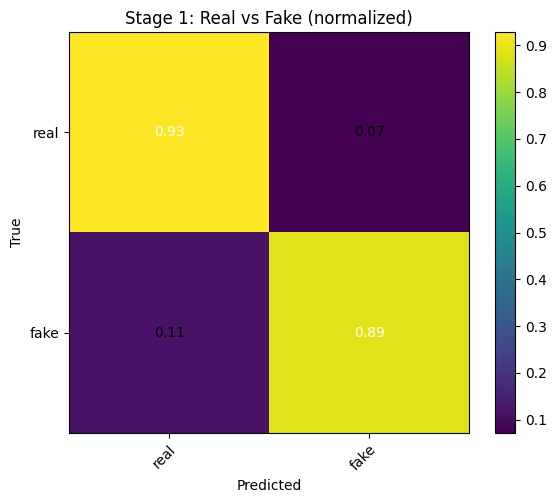


Classification Report:
              precision    recall  f1-score   support

        real      0.880     0.928     0.903      7461
        fake      0.931     0.886     0.908      8252

    accuracy                          0.906     15713
   macro avg      0.906     0.907     0.906     15713
weighted avg      0.907     0.906     0.906     15713


========== Stage 2: 14-class (13 known + unknown) ==========
Confusion Matrix:
[[ 281    0    0    0    0    0    0    0    0    0    0    0    0    2]
 [   0  140    0    0    0    1    0    0    0    0    0    0    0    0]
 [   0    0   73    0    0    0    0    0    3    4    0    0    0    9]
 [   0    0    0  485    0    0    0    0    0    0    0    0    0    1]
 [   0    0    0    0  914    0    0    1    0    0    0    0    0    1]
 [   0    0    0    0    0  496    0    0    0    0    0    0    0    0]
 [   1    0    0    3    0    1  446    0    0    0    0    0    0    3]
 [   0    0    0    0    1    0    1  616    0    0    0  

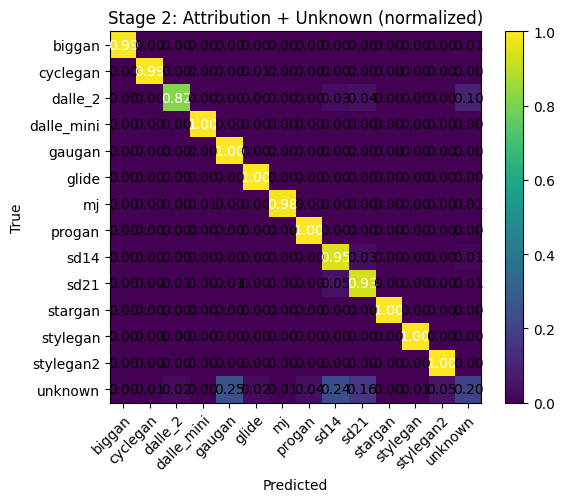


Classification Report:
              precision    recall  f1-score   support

      biggan      0.996     0.993     0.995       283
    cyclegan      0.986     0.993     0.989       141
     dalle_2      0.924     0.820     0.869        89
  dalle_mini      0.994     0.998     0.996       486
      gaugan      0.953     0.998     0.975       916
       glide      0.986     1.000     0.993       496
          mj      0.996     0.982     0.989       454
      progan      0.981     0.997     0.989       618
        sd14      0.863     0.946     0.902       405
        sd21      0.888     0.930     0.909       385
     stargan      1.000     1.000     1.000       303
    stylegan      0.998     0.998     0.998      1118
   stylegan2      0.993     0.998     0.996      1445
     unknown      0.576     0.201     0.298       169

    accuracy                          0.970      7308
   macro avg      0.938     0.918     0.921      7308
weighted avg      0.965     0.970     0.965      7308




In [ ]:
import os
import numpy as np

_required_symbols = [
    'ResidualBinaryDataset', 'residualizer', 'val_tfms_geometric', '_split_indices',
    'binary_model', 'attr_model', 'attr_classes'
]
_missing = [s for s in _required_symbols if s not in globals()]
if _missing:
    raise RuntimeError(
        f"[필수 심볼 누락] 다음 객체/함수들이 현재 네임스페이스에 없습니다: {_missing}\n"
        "→ 모델 로딩/데이터 정의 파트(앞부분)를 먼저 실행했는지 확인해 주세요."
    )

if 'device' not in globals():
    import torch
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if '_plot_cm' not in globals():
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay

    def _plot_cm(cm, class_names, title="Confusion Matrix (normalized)"):
        if cm is None:
            return
        # 정규화
        with np.errstate(all='ignore'):
            cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
            cm_norm = np.nan_to_num(cm_norm)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(6, 6))
        disp.plot(values_format=".2f", ax=ax, colorbar=False)
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        plt.tight_layout()
        plt.show()

if 'evaluate_two_stage_with_unknown' not in globals():
    raise RuntimeError(
        "[함수 누락] evaluate_two_stage_with_unknown 가 정의되어 있지 않습니다.\n"
        "→ 먼저 패치된 함수 정의 블록(# --- PATCH START --- ~ # --- PATCH END ---)을 실행해 주세요."
    )

BASE_DATASET_ROOT = globals().get('BASE_DATASET_ROOT', "/content/prnu_dataset/data")
UNKNOWN_DIR = globals().get('UNKNOWN_DIR', "/content/unknown")
VAL_RATIO = globals().get('VAL_RATIO', 0.2)
SEED = globals().get('SEED', 42)

FAKE_THRESHOLD = globals().get('FAKE_THRESHOLD', 0.5)       # Stage-1 fake 판정 임계치
UNKNOWN_THRESHOLD = globals().get('UNKNOWN_THRESHOLD', 0.5) # Stage-2 unknown 판정 임계치

if not os.path.isdir(UNKNOWN_DIR):
    print(f"[경고] UNKNOWN_DIR가 없습니다: {UNKNOWN_DIR}\n→ unknown 폴더가 없으면 Stage-2에서 unknown 샘플이 없어도 정상 동작하긴 합니다.")
else:
    pngs = [f for f in os.listdir(UNKNOWN_DIR) if f.lower().endswith(".png")]
    print(f"[INFO] unknown png 개수: {len(pngs)} @ {UNKNOWN_DIR}")

try:
    binary_model.to(device)
    attr_model.to(device)
except Exception as e:
    print("[주의] 모델 device 이동 중 메시지(무시 가능):", e)

results_unknown = evaluate_two_stage_with_unknown(
    base_dataset_root=BASE_DATASET_ROOT,
    unknown_dir=UNKNOWN_DIR,
    binary_model=binary_model,
    attr_model=attr_model,
    attr_class_names=attr_classes,  # 길이 13
    val_ratio=VAL_RATIO,
    seed=SEED,
    batch_size=64,
    tta=True,
    fake_threshold=FAKE_THRESHOLD,
    unknown_threshold=UNKNOWN_THRESHOLD,
)

cm1 = results_unknown["cm_stage1"]
cm2 = results_unknown["cm_stage2"]
class_names_14 = results_unknown["class_names_14"]

print("\n[요약] Stage-1 CM shape:", None if cm1 is None else cm1.shape)
print("[요약] Stage-2 CM shape:", None if cm2 is None else cm2.shape)
print("[요약] 클래스(14개):", class_names_14)
